In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 32
num_epochs = 100

z_dimension = 100
num_feature = 56 * 56

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('./datas', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2), 
        ) # b 32 14 14
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2),
        ) # b 64 7 7
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
    
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
        
        out = out.view(x.size(0), -1)
        return self.fc(out)

In [7]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, num_feature)
        ) # b h*w
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.LeakyReLU(.2, True),
        ) # b 1 56 56
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
        ) # b 64 56 56
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
        ) # b 32 56 56
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1, stride=2),
            nn.Tanh(),
        ) # b 1 28 28
        
    def forward(self, x):
        out = self.fc(x)
        
        out = out.view(x.size(0), 1, 56, 56)
        out = self.br(out)
        out = self.downsample1(out)
        out = self.downsample2(out)
        out = self.downsample3(out)
        return out

In [8]:
d = Discriminator().to(device)
g = Generator(z_dimension, num_feature).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=1e-4)
g_optimezer = optim.Adam(g.parameters(), lr=1e-4)

In [9]:
writer = SummaryWriter('./log/cnn_gan')

In [10]:
total_count = len(dataloader)
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        real_labels = torch.ones(img.size(0), 1).cuda()
        fake_labels = torch.zeros(img.size(0), 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        step = epoch * total_count + i + 1
        
        writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
        writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
        writer.add_scalar('Discriminator Loss', d_loss.item(), step)
        writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 500 == 0:
            print 'Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean())
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 28, 28).cpu().data
        save_image(real_images, './cnn_gan_img/real_images.png')

    fake_images = fake_img.view(-1, 1, 28, 28).cpu().data
    save_image(fake_images, './cnn_gan_img/fake_images-{}.png'.format(epoch+1))

Epoch [1/100], Step:  16000, d_loss: 0.447707, g_loss: 0.972548, real_scores: 0.875926, fake_scores: 0.220894
Epoch [1/100], Step:  32000, d_loss: 0.588346, g_loss: 1.651088, real_scores: 0.758777, fake_scores: 0.218019
Epoch [1/100], Step:  48000, d_loss: 0.422349, g_loss: 2.128111, real_scores: 0.835960, fake_scores: 0.181344
Epoch [2/100], Step:  16000, d_loss: 0.659415, g_loss: 2.391714, real_scores: 0.952546, fake_scores: 0.383948
Epoch [2/100], Step:  32000, d_loss: 0.293448, g_loss: 2.903997, real_scores: 0.923110, fake_scores: 0.150144
Epoch [2/100], Step:  48000, d_loss: 0.321554, g_loss: 1.613950, real_scores: 0.932759, fake_scores: 0.177828
Epoch [3/100], Step:  16000, d_loss: 0.462831, g_loss: 3.195925, real_scores: 0.914801, fake_scores: 0.256083
Epoch [3/100], Step:  32000, d_loss: 0.469265, g_loss: 1.662153, real_scores: 0.800443, fake_scores: 0.080927
Epoch [3/100], Step:  48000, d_loss: 0.300416, g_loss: 2.891566, real_scores: 0.870517, fake_scores: 0.106174
Epoch [4/1

Epoch [26/100], Step:  16000, d_loss: 0.512827, g_loss: 3.295505, real_scores: 0.839873, fake_scores: 0.078204
Epoch [26/100], Step:  32000, d_loss: 0.477461, g_loss: 4.188879, real_scores: 0.846053, fake_scores: 0.038849
Epoch [26/100], Step:  48000, d_loss: 0.488970, g_loss: 2.920677, real_scores: 0.797888, fake_scores: 0.071363
Epoch [27/100], Step:  16000, d_loss: 0.784063, g_loss: 2.546706, real_scores: 0.823910, fake_scores: 0.262032
Epoch [27/100], Step:  32000, d_loss: 0.307745, g_loss: 2.138925, real_scores: 0.947818, fake_scores: 0.188435
Epoch [27/100], Step:  48000, d_loss: 0.475131, g_loss: 3.361176, real_scores: 0.800968, fake_scores: 0.055124
Epoch [28/100], Step:  16000, d_loss: 0.393286, g_loss: 3.425052, real_scores: 0.835607, fake_scores: 0.057526
Epoch [28/100], Step:  32000, d_loss: 0.405798, g_loss: 2.640990, real_scores: 0.848358, fake_scores: 0.127495
Epoch [28/100], Step:  48000, d_loss: 0.200334, g_loss: 3.211935, real_scores: 0.925625, fake_scores: 0.067133
E

Epoch [50/100], Step:  48000, d_loss: 0.489291, g_loss: 2.436440, real_scores: 0.869971, fake_scores: 0.097555
Epoch [51/100], Step:  16000, d_loss: 0.413962, g_loss: 2.270707, real_scores: 0.884833, fake_scores: 0.183947
Epoch [51/100], Step:  32000, d_loss: 0.462508, g_loss: 3.038633, real_scores: 0.839895, fake_scores: 0.067576
Epoch [51/100], Step:  48000, d_loss: 0.397672, g_loss: 2.399278, real_scores: 0.891989, fake_scores: 0.130665
Epoch [52/100], Step:  16000, d_loss: 0.572343, g_loss: 1.601494, real_scores: 0.834877, fake_scores: 0.229213
Epoch [52/100], Step:  32000, d_loss: 0.316383, g_loss: 2.299988, real_scores: 0.899689, fake_scores: 0.124535
Epoch [52/100], Step:  48000, d_loss: 0.319533, g_loss: 2.242620, real_scores: 0.888876, fake_scores: 0.124586
Epoch [53/100], Step:  16000, d_loss: 0.549893, g_loss: 2.609358, real_scores: 0.809731, fake_scores: 0.087106
Epoch [53/100], Step:  32000, d_loss: 0.387688, g_loss: 3.365582, real_scores: 0.877945, fake_scores: 0.064743
E

Epoch [75/100], Step:  32000, d_loss: 0.414587, g_loss: 2.389448, real_scores: 0.866606, fake_scores: 0.124409
Epoch [75/100], Step:  48000, d_loss: 0.494127, g_loss: 2.121598, real_scores: 0.836678, fake_scores: 0.137126
Epoch [76/100], Step:  16000, d_loss: 0.545136, g_loss: 2.652172, real_scores: 0.816078, fake_scores: 0.113644
Epoch [76/100], Step:  32000, d_loss: 0.349267, g_loss: 1.937458, real_scores: 0.891234, fake_scores: 0.118762
Epoch [76/100], Step:  48000, d_loss: 0.446829, g_loss: 3.377032, real_scores: 0.865556, fake_scores: 0.073076
Epoch [77/100], Step:  16000, d_loss: 0.547785, g_loss: 2.310656, real_scores: 0.826981, fake_scores: 0.127553
Epoch [77/100], Step:  32000, d_loss: 0.508228, g_loss: 3.385291, real_scores: 0.857941, fake_scores: 0.089290
Epoch [77/100], Step:  48000, d_loss: 0.452473, g_loss: 2.667303, real_scores: 0.858265, fake_scores: 0.074712
Epoch [78/100], Step:  16000, d_loss: 0.375978, g_loss: 2.523567, real_scores: 0.857072, fake_scores: 0.090194
E

Epoch [100/100], Step:  16000, d_loss: 0.166139, g_loss: 2.225789, real_scores: 0.979476, fake_scores: 0.123475
Epoch [100/100], Step:  32000, d_loss: 0.387946, g_loss: 2.721331, real_scores: 0.860175, fake_scores: 0.074702
Epoch [100/100], Step:  48000, d_loss: 0.254766, g_loss: 2.280879, real_scores: 0.926064, fake_scores: 0.111063


In [11]:
writer.close()

In [12]:
torch.save(d.state_dict(), './ser/discriminator.pkl')
torch.save(g.state_dict(), './ser/generator.pkl')

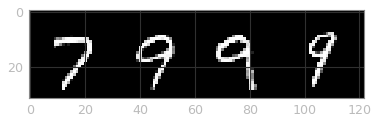

In [24]:
z = torch.randn(4, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()